In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from astropy.stats import LombScargle

from maelstrom.model import InterpMaelstrom
from maelstrom.estimator import estimate_frequencies

/Users/dforeman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
kicid = 11754974
# kicid = 7917485

data = np.loadtxt("data/kic{0}_lc.txt".format(kicid))
fulltimes = data[:, 0] # days
tmid = 0.5*(fulltimes[0] + fulltimes[-1])
times = fulltimes - tmid
dmmags = data[:, 1] * 1000. # mmags

# times = times[2500:]
# dmmags = dmmags[2500:]

metadata = np.loadtxt("data/kic{0}_metadata.csv".format(kicid), delimiter=",", skiprows=1)
nu_arr = metadata[::6]

# orbits = pd.read_csv("data/orbits.csv").rename(columns = lambda x: x.strip())

# orb_params = orbits[orbits.Name == "kic{0}".format(kicid)].iloc[0]
# porb = orb_params.Porb
# a1 = orb_params["a1sini/c"]
# tp = orb_params["t_p"] - tmid
# e = orb_params["e"]
# varpi = orb_params["varpi"]
# a1d = a1/86400.0

In [4]:
nu = estimate_frequencies(times, dmmags)
nu

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 2177604.352412
  Number of iterations: 22
  Number of functions evaluations: 33


array([ 16.3447547 ,  21.39900309,  20.90743268,  20.94356652,
         4.56267898,  32.68951188])

In [85]:
N = 2000
model = InterpMaelstrom(times, dmmags, nu_arr[:2], log_sigma2=0.0,
                        interp_x=np.linspace(times.min(), times.max(), N),
                        interp_y=1e-5*np.random.randn(N))
# model.init_from_orbit(period=porb, lighttime=a1d, tref=tp, eccen=e, varpi=varpi)

In [86]:
# model.chi2 += 1e5*tf.square(tf.reduce_mean(model.interp_y))
log_lam = tf.Variable(-10.0, dtype=model.T)
model.run(log_lam.initializer)

# log_lam2 = tf.Variable(-1.0, dtype=model.T)
# model.run(log_lam2.initializer)

# # log_lam3 = tf.Variable(-5.0, dtype=model.T)
# # model.run(log_lam3.initializer)

# model.chi2 += tf.exp(-log_lam1)*tf.reduce_sum(tf.square(model.interp_y)) + N*log_lam1
# model.chi2 += tf.exp(-log_lam)*tf.reduce_sum(tf.square(model.interp_y[1:]-model.interp_y[:-1])) + (N-1)*log_lam
# # model.chi2 += tf.exp(-log_lam3)*tf.square(tf.reduce_mean(model.interp_y)) + log_lam3

In [87]:
opt = tf.train.AdamOptimizer().minimize(
    model.chi2, var_list=[model.interp_y, model.log_sigma2])
model.run(tf.global_variables_initializer())

In [88]:
model.optimize([model.log_sigma2, model.nu])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 310008.768868
  Number of iterations: 32
  Number of functions evaluations: 39


In [95]:
for i in range(1000):
    chi2, _ = model.run([model.chi2, opt])
    if i%100 == 0:
        print(chi2)

303676.202789
303675.229058
303675.441241
303675.809373
303676.320161
303676.351361
303676.904151
303677.196195
303677.28367
303676.559626


In [96]:
model.run(model.chi2)

303676.03907339275

In [97]:
model.optimize([log_lam, model.log_sigma2, model.nu])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 303675.965013
  Number of iterations: 4
  Number of functions evaluations: 11


In [98]:
np.sqrt(np.exp(model.run([model.log_sigma2, log_lam])))

array([  1.20940693e+01,   6.73794700e-03])

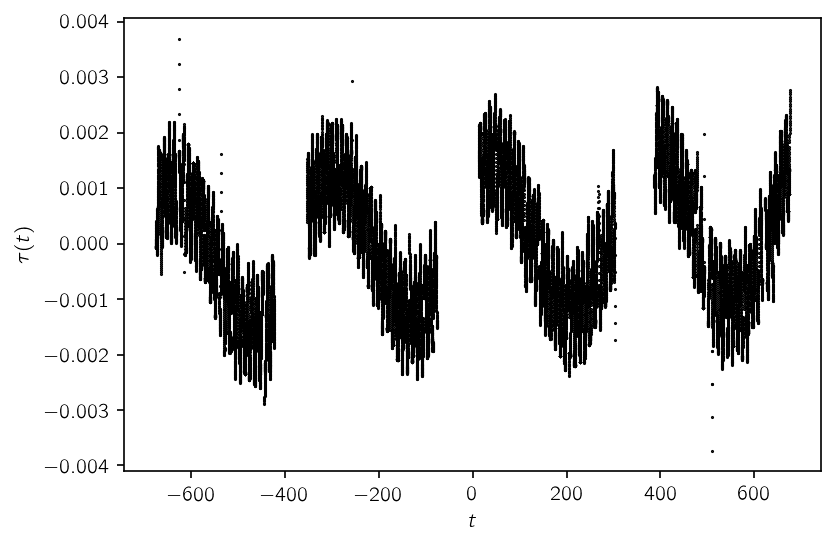

In [99]:
plt.plot(times, model.run(model.psi), ".k", ms=1)
# plt.plot(*(model.run([model.interp_x, model.interp_y])))
# plt.ylim(-0.002, 0.005)
plt.ylabel(r"$\tau(t)$")
plt.xlabel("$t$");

(50, 150)

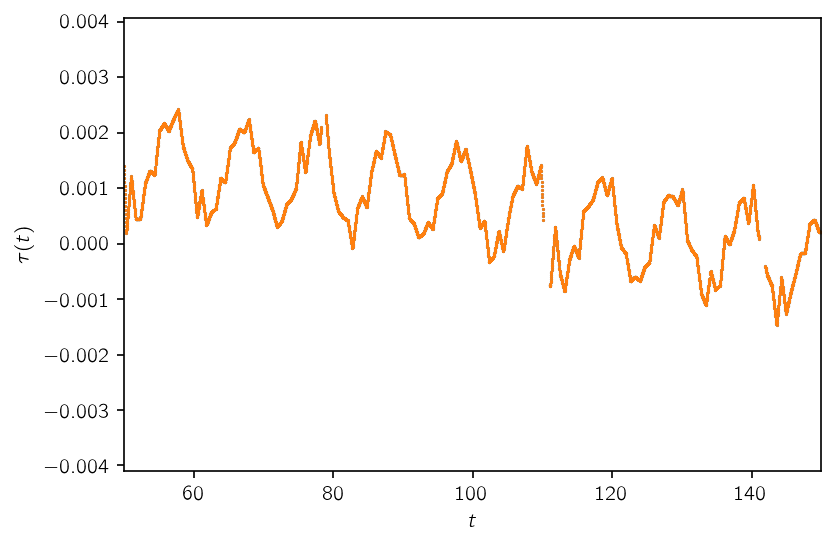

In [103]:
plt.plot(times, model.run(model.tau), ".", ms=1)
plt.ylabel(r"$\tau(t)$")
plt.xlabel("$t$");
plt.xlim(50, 150)

In [72]:
tau = model.run(model.psi)

In [74]:
from astropy.stats import LombScargle

freq, power = LombScargle(times, tau).autopower()

In [82]:
m = (1/freq < 100) & (1 < 1/freq)
1.0 / freq[m][np.argmax(power[m])], 1.0 / freq[np.argmax(power)]

(10.494156564879583, 346.3071666410263)

(1, 1000)

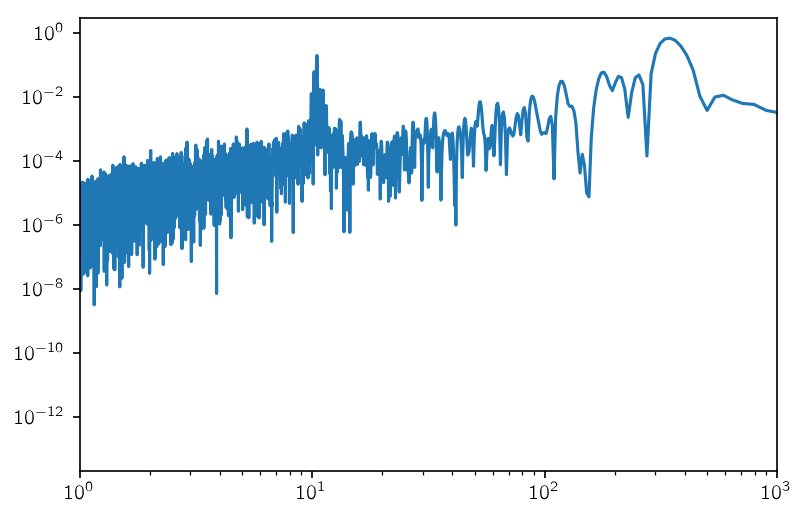

In [79]:
plt.loglog(1./freq, power)
plt.xlim(1, 1000)